In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import pickle
from importlib import reload

import torch
import matplotlib
import numpy as np
import pandas as pd
import sciplots as plots
import matplotlib.pyplot as plt
import netloader.networks as nets
from scipy import stats
from scipy.optimize import curve_fit
from sklearn.decomposition import PCA
from sciplots.utils import label_change
from mpl_toolkits.axes_grid1 import make_axes_locatable
from netloader.data import loader_init
from netloader import transforms

from src import main
from src.utils import data
from src.utils import analysis
from src.utils.utils import open_config, overlap

reload(plots.base)
reload(plots.single_plots)
reload(plots)
reload(data)
reload(analysis)
reload(main)

# matplotlib.rc('text', usetex=True)
matplotlib.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}\usepackage{siunitx}\sisetup{detect-all}\usepackage{helvet}\usepackage{sansmath}\sansmath'
matplotlib.rcParams['axes.grid'] = True

import sciplots as plots
from src.utils import analysis
from src.utils.data import DarkDataset

In [3]:
_, config = open_config('main', '../config.yaml')

net_epochs = config['training']['epochs']
states_dir = config['output']['network-states-directory']
plots_dir = os.path.join(config['output']['plots-directory'], 'final_plots')

major=34
minor=30
quantile_values = (0.5, 0.05, 0.16, 0.84, 0.95)
bahamas_colours = ['#0008E0', '#004FE0', '#0097E0', '#00DCE0']
bahamas_agn_colours = ['#F54EDF', '#5D4EF5'][::-1]
bahamas_dmo = ['#00FA8F', '#01FB3D', '#89FA00']
flamingo_colours = ['#FABD00', '#FA7700', '#FA2100']
flamingo_test = ['#FA00BA']

In [4]:
def probs_distributions(predictions, quantile_values):
    data_pred = dict(zip(
        predictions.flatten()[0].keys(),
        [np.empty_like(predictions) for _ in range(len(predictions.flatten()[0].keys()))],
    ))

    for key in data_pred:
        for shape in np.ndindex(predictions.shape):
            data_pred[key][*shape] = predictions[*shape][key].copy()

    for key in data_pred:
        try:
            data_pred[key] = np.array(data_pred[key].tolist())
        except ValueError:
            pass

    if 'latent' not in data_pred:
        for shape in np.ndindex(data_pred['preds'].shape[:2]):
            data_pred['preds'][*shape] = data['nets'][*shape, 0].transforms['targets'][1:](data_pred['preds'][*shape])

    data_pred['targets'] = data_pred['targets'].squeeze(axis=-1)
    distributions = analysis.distributions(
        data_pred['latent'][..., 0] if 'latent' in data_pred else data_pred['preds'].squeeze(axis=-1),
        dataset.low_dim[data_pred['ids'].astype(int)].squeeze(axis=-1),
    )
    grids, new_distributions = analysis.mult_distributions(distributions, bins=500)

    for shape in np.ndindex(grids.shape[:-1]):
        grids[*shape] = data['nets'][*shape, 0].transforms['targets'](grids[*shape], back=True)

    probs = np.empty_like(new_distributions)
    cumsums = probs.copy()
    quantiles = np.empty((len(quantile_values) + 2, *cumsums.shape[:-1]))

    for shape in np.ndindex(new_distributions.shape[:-1]):
        probs[*shape] = new_distributions[*shape] / np.trapezoid(new_distributions[*shape], np.log10(grids[*shape[:-1]]))
        cumsums[*shape] = np.cumsum(probs[*shape] / np.sum(probs[*shape]))

        for i, percentile in enumerate(quantile_values):
            quantiles[i, *shape] = grids[*shape[:-1], np.argmin(np.abs(cumsums[*shape] - percentile), axis=-1)]

    quantiles[-2] = quantiles[0] - quantiles[2]
    quantiles[-1] = quantiles[3] - quantiles[0]

    return data_pred, distributions, new_distributions, grids, probs, quantiles

def mean_ste_index(means, stes, idxs, fixed_idxs, dim, min):
    new_means = []
    new_stes = []

    for idx, mean, ste in zip(idxs, means[*fixed_idxs].swapaxes(0, dim), stes[*fixed_idxs].swapaxes(0, dim)):
        min_idx = np.argmin(mean[idx]) if min else np.argmax(mean[idx])
        new_means.append(mean[idx][min_idx])
        new_stes.append(ste[idx][min_idx])

    return new_means, new_stes

In [5]:
def merge_plots(plot_base, plot_append):
    plot_base._y_data = list(plot_base._y_data) if isinstance(plot_base._y_data, np.ndarray) else plot_base._y_data

    for line, poly in zip(plot_append.plots[plot_append.axes][::2], plot_append.plots[plot_append.axes][1::2]):
        line.remove()
        poly.remove()
        plot_append.plots[plot_append.axes].remove(line)
        plot_append.plots[plot_append.axes].remove(poly)

        line.set_ydata(line.get_ydata() / np.trapezoid(line.get_ydata(), np.log10(line.get_xdata())))
        verts = poly.get_paths()[0].vertices
        verts[:, 1] = verts[:, 1] / np.sum(verts[:, 1])
        poly.set_verts([verts])

        plot_append.axes.add_line(line)
        plot_append.axes.add_collection(poly)
        plot_append.plots[plot_append.axes].append(line)
        plot_append.plots[plot_append.axes].append(poly)

    for line in plot_append.plots[plot_append.axes][::2]:
        plot_base.plots[plot_base.axes].append(
            plot_base.axes.plot(*line.get_xydata().swapaxes(0, 1), color=line.get_color(), alpha=0.4, ls='-')[0])
        plot_base._data.append(line.get_xdata())
        plot_base._y_data.append(line.get_ydata())

    plot_base.axes.set_xlim(min([min(datum[y_datum > 1e-4]) for datum, y_datum in zip(plot_base._data, plot_base._y_data)]),
                            max([max(datum[y_datum > 1e-4]) for datum, y_datum in zip(plot_base._data, plot_base._y_data)]))

In [6]:
def gen_predictions(nets, dataset, labels, images, idxs=None):
    predictions = np.empty(nets.shape, dtype=object)

    for shape in np.ndindex(predictions.shape):
        if shape[-1] == 0:
            nets[*shape].transforms['inputs'][1]._shape = images.shape[1:]
            dataset.high_dim = nets[*shape].transforms['inputs'](images.copy())
            dataset.low_dim = nets[*shape].transforms['targets'](labels.copy())

            loaders = loader_init(
                dataset,
                batch_size=config['training']['batch-size'],
                ratios=(1 - config['training']['validation-fraction'], config['training']['validation-fraction']) if idxs is None and nets[*shape].idxs is None else (1,),
                idxs=dataset.idxs[np.isin(dataset.extra['ids'], nets[*shape].idxs)] if idxs is None and nets[*shape].idxs is not None else idxs,
            )
            print(f'Loader Dataset Lengths: {[len(loader.dataset) for loader in loaders]}')

        if predictions[*shape] is None:
            nets[*shape].to('cuda')
            predictions[*shape] = nets[*shape].predict(loaders[1])
            nets[*shape].to('cpu')
            torch.cuda.empty_cache()

    return predictions

# BAHAMAS Tests

In [7]:
dataset = DarkDataset(
    config['data']['data-dir'],
    [
        'bahamas_cdm',
        'bahamas_cdm_low',
        'bahamas_cdm_hi',
        'bahamas_0.1',
        'bahamas_0.3',
        'bahamas_1',
        'flamingo_low',
        'flamingo_hi',
        'flamingo',
        'flamingo_low_test',
    ],
    [],
)
dataset.low_dim = dataset.unique_labels(dataset.low_dim, dataset.extra['sims'])
dataset_labels = dataset.low_dim.copy()
images = dataset.high_dim[:, :2].copy()
labels = dataset.extra['names'].iloc[np.unique(dataset.low_dim, return_index=True)[1]].to_numpy()
# labels = np.array([r'$\textsc{' + label + '}$' if label.lower() != 'noise' else label for label in labels])
images.shape

(40600, 2, 100, 100)

In [8]:
batch_num = 46
torch.manual_seed(0)
np.random.seed(0)
data = analysis.batch_train_summary(batch_num, '../data/')

if isinstance(data['nets'].flatten()[0], str):
    data['nets'] = data['nets'].astype(object)
    for shape in np.ndindex(data['nets'].shape):
        data['nets'][*shape] = torch.load(data['nets'][*shape], weights_only=False, map_location='cpu')

data['nets'].shape

(1, 8, 3)

In [9]:
with open(f'../data/temp_batch_predictions_{batch_num}.pkl', 'rb') as file:
    predictions = pickle.load(file)

In [ ]:
predictions = gen_predictions(data['nets'], dataset, dataset_labels, images)

In [159]:
with open('../data/temp_batch_predictions_46.pkl', 'wb') as file:
    pickle.dump(predictions, file)

In [10]:
data_pred, distributions, new_distributions, grids, probs, quantiles = probs_distributions(predictions, quantile_values)
distributions.shape, new_distributions.shape, grids.shape, probs.shape, quantiles.shape

((1, 7, 3, 10), (1, 7, 10, 500), (1, 7, 500), (1, 7, 10, 500), (7, 1, 7, 10))

In [11]:
proj_vecs = np.empty(data_pred['latent'].shape[:-2], dtype=object)

for shape in np.ndindex(data_pred['latent'].shape[:-2]):
    proj_vecs[*shape] = analysis.proj_all_inter_1d(data_pred['latent'][..., 1:][*shape], data_pred['targets'][*shape])

proj_vecs = np.array(proj_vecs.tolist(), dtype=object)
proj_vecs = proj_vecs.swapaxes(-2, -1)

bins = 500
cdfs = np.empty((*proj_vecs.shape, bins), dtype=float)

for shape in np.ndindex(proj_vecs.shape[:-1]):
    grid = np.mgrid[np.min(np.concat(proj_vecs[*shape])):np.max(np.concat(proj_vecs[*shape])):bins * 1j]
    cdfs[*shape] = [
        analysis.distribution_func(proj_vecs[*shape, 0], norm=True, cumulative=True, grid=grid)[1],
        analysis.distribution_func(proj_vecs[*shape, 1], norm=True, cumulative=True, grid=grid)[1],
    ]

emds = np.mean(np.subtract(cdfs[..., 0, :], cdfs[..., 1, :]), axis=-1)
overlaps = np.empty(proj_vecs.shape[:-1], dtype=float)

for shape in np.ndindex(overlaps.shape):
    overlaps[*shape] = overlap(*proj_vecs[*shape])

emd_means = np.mean(emds, axis=-3)
emd_stes = np.std(emds, axis=-3, ddof=1) / np.sqrt(emds.shape[-3])
overlap_means = np.mean(overlaps, axis=-3)
overlap_stes = np.std(overlaps, axis=-3, ddof=1) / np.sqrt(overlaps.shape[-3])
proj_vecs.shape, emd_means.shape

((1, 7, 3, 10, 9, 2), (1, 7, 10, 9))

# BAHAMAS-0.1 Unknown

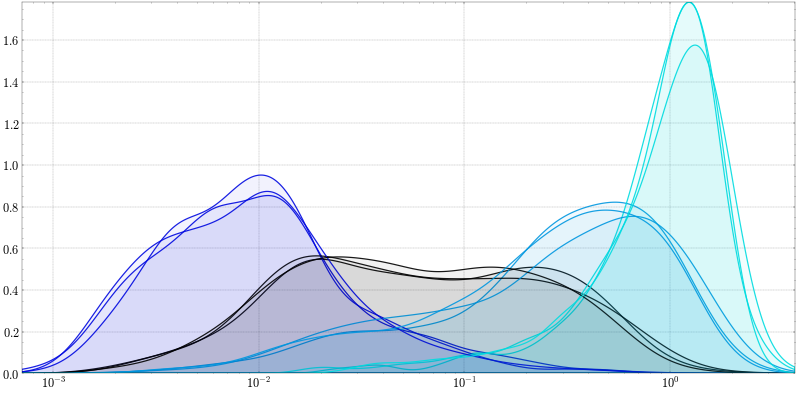

In [114]:
idx = (-1, 0)
sim_idx = np.arange(len(labels))[slice(6, None)]
colours = np.array(bahamas_colours[:1] + ['k'] + bahamas_colours[2:])
plot = plots.PlotDistribution(
    data['nets'][*idx, 0].transforms['targets'](distributions[*idx][:, sim_idx].reshape(-1), back=True),
    log=True,
    y_axes=True,
    density=True,
    colours=np.tile(colours, distributions.shape[-2]).tolist(),
    bins=500,
    alpha_2d=0.05,
    fig_size=(8, 4),
)

,50%,5%,16%,84%,95%,-,+
BAHAMAS-0,0.00863,0.00288,0.00430,0.01455,0.02026,0.00433,0.00592
BAHAMAS-0.1,0.04758,0.01101,0.01673,0.20554,0.35273,0.03085,0.15797
BAHAMAS-0.3,0.47430,0.12620,0.23628,0.82824,1.09447,0.23802,0.35394
BAHAMAS-1,1.19408,0.67199,0.87267,1.52388,1.75177,0.32141,0.32981


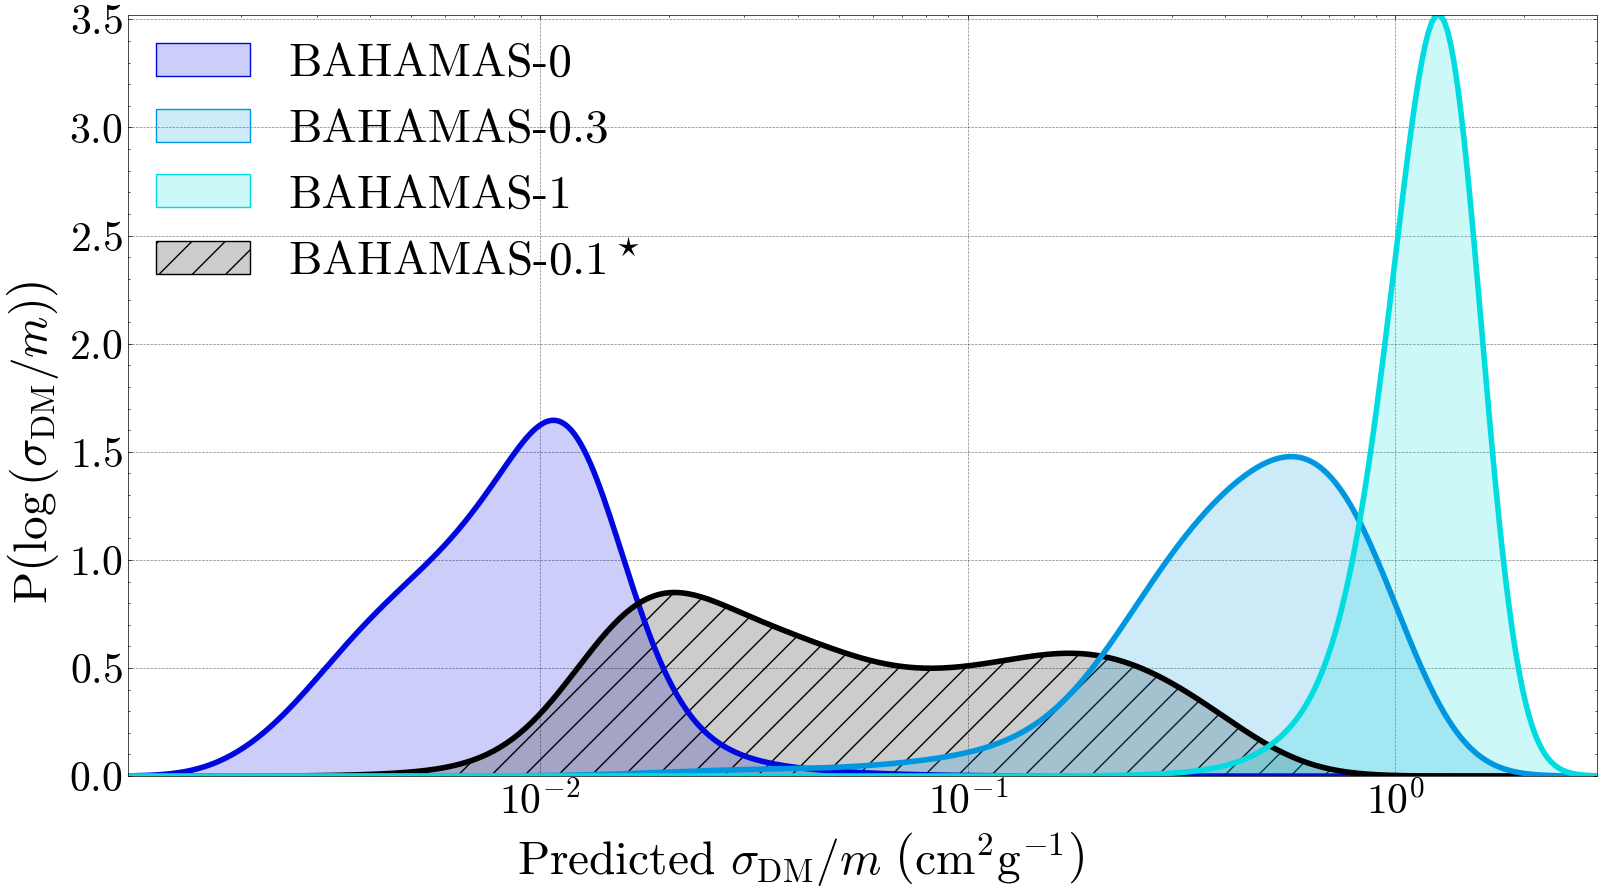

In [115]:
styles = np.array(['-'] * len(labels[sim_idx]), dtype=object)
styles[colours == 'k'] = '--'
hatches = np.array([''] * len(labels[sim_idx]), dtype=object)
hatches[colours == 'k'] = '/'
new_labels = labels[sim_idx].copy().astype(object)
new_labels[colours == 'k'] = new_labels[colours == 'k'] + rf'$^\star$'
plot2 = plots.PlotPlots(
    grids[*idx],
    probs[*idx, sim_idx],
    log_x=True,
    x_label=r'Predicted $\sigma_{\rm DM}/m\ \left(\rm cm^2g^{-1}\right)$',
    y_label=r'${\rm P}\left(\log{\left(\sigma_{\rm DM}/m\right)}\right)$',
    # styles=styles,
    styles='-',
    labels=new_labels,
    colours=colours,
    frameon=False,
    alpha_2d=0.2,
    major=major,
    minor=minor,
    line_width=4,
    axis=True,
    cols=1,
    loc='upper left',
    label_permute=[0, 2, 3, 1],
)
for label, colour, hatch, y_datum in zip(new_labels, colours, hatches, probs[*idx, sim_idx]):
    plot2.plots[plot2.axes].append(plot2.axes.fill_between(
        grids[*idx],
        y_datum,
        hatch=hatch,
        label=label,
        facecolor=(colour, plot2._alpha_2d),
        edgecolors=(colour, plot2._alpha_line),
    ))
plot2.create_legend(**plot2._legend_kwargs)
plot2.axes.set_xlim(np.min(np.array(plot2._data)[(np.array(plot2._y_data) > 1e-3)]), np.max(np.array(plot2._data)[(np.array(plot2._y_data) > 1e-3)]))
# merge_plots(plot2, plot)
plot2.savefig(plots_dir, name='bahamas-0.1_distribution')
pd.DataFrame(quantiles[:, *idx, sim_idx].swapaxes(0, 1), index=labels[sim_idx], columns=[f'{quantile:.0%}' for quantile in list(quantile_values)] + ['-', '+']).round(5)

,BAHAMAS-0,BAHAMAS-0.3,BAHAMAS-1
Mean,48.83,55.32,13.60
STE,0.25,0.98,0.52


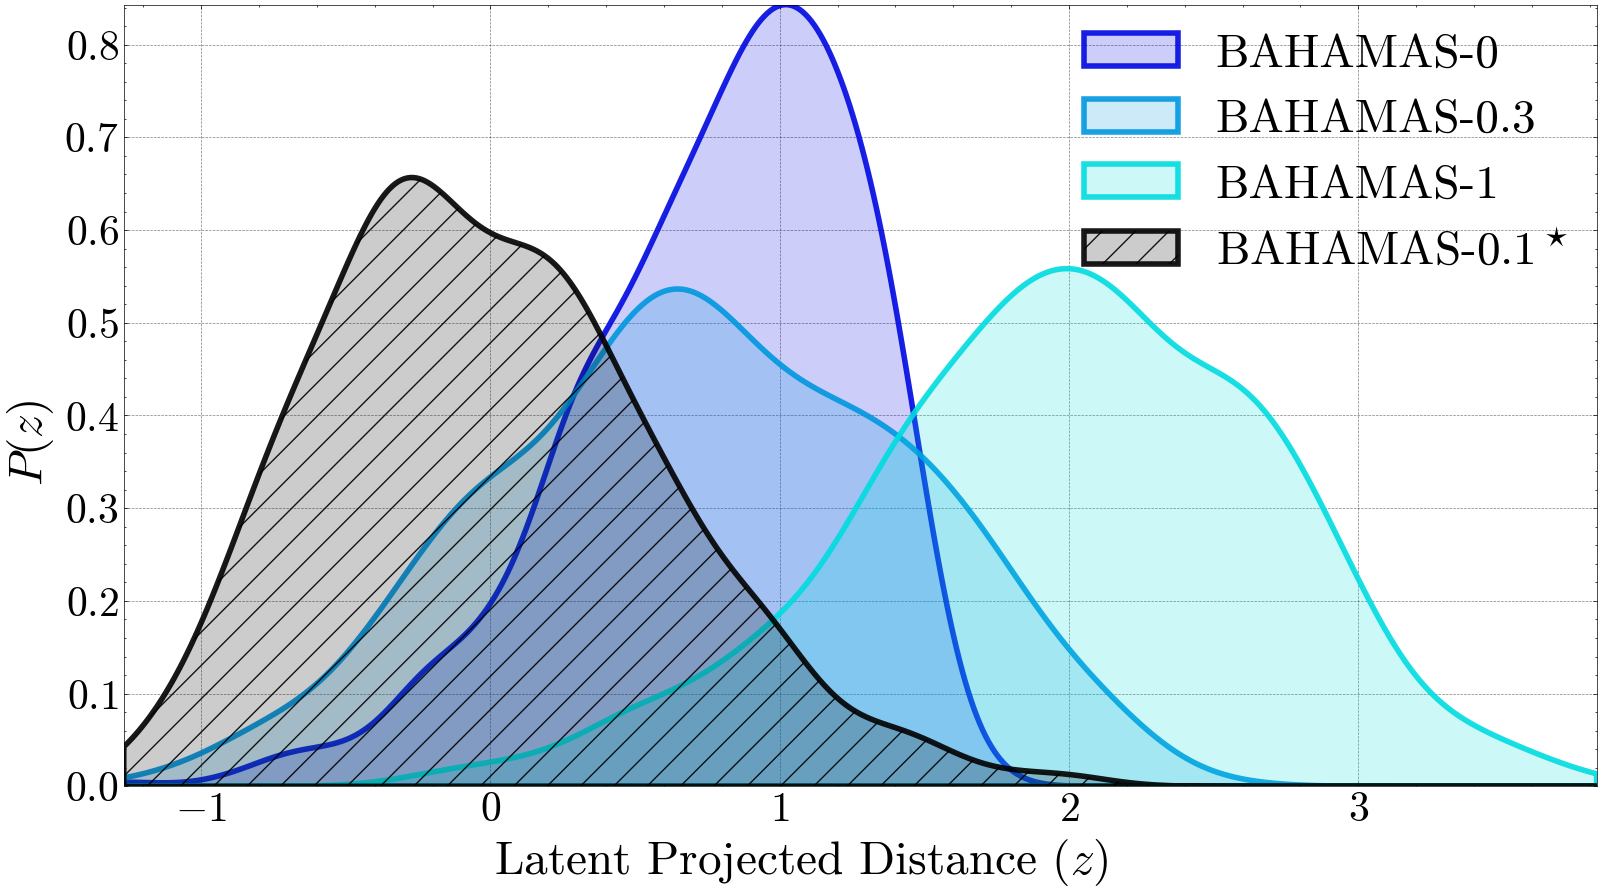

In [116]:
mmd_idx = 1
sub_sim_idx = sim_idx[sim_idx != sim_idx[mmd_idx]]
sub_sim_idx = np.where(sub_sim_idx > sim_idx[mmd_idx], sub_sim_idx - 1, sub_sim_idx)
sub_proj_vecs = proj_vecs[*idx, 0, sim_idx[mmd_idx], sub_sim_idx]

plot = plots.PlotDistribution(
    [*sub_proj_vecs[:, 1], sub_proj_vecs[1, 0]],
    y_axes=True,
    density=True,
    # norm=True,
    bins=500,
    x_labels='Latent Projected Distance $(z)$',
    y_labels='$P(z)$',
    colours=np.append(np.array(colours)[np.arange(len(colours)) != mmd_idx], colours[mmd_idx]),
    labels=np.append(new_labels[np.arange(len(new_labels)) != mmd_idx], new_labels[mmd_idx]),
    hatches=[''] * (len(new_labels) - 1) + ['/'],
    axis=True,
    frameon=False,
    cols=1,
    line_width=4,
    alpha_2d=0.2,
    major=major,
    minor=minor,
    loc='upper right',
)
plot.savefig(plots_dir, name='bahamas-0.1_mmd')
pd.DataFrame((overlap_means[*idx, sim_idx[mmd_idx], sub_sim_idx], overlap_stes[*idx, sim_idx[mmd_idx], sub_sim_idx]), index=['Mean', 'STE'], columns=new_labels[np.arange(len(new_labels)) != mmd_idx]).round(4) * 100

# BAHAMAS-0.3 Unknown

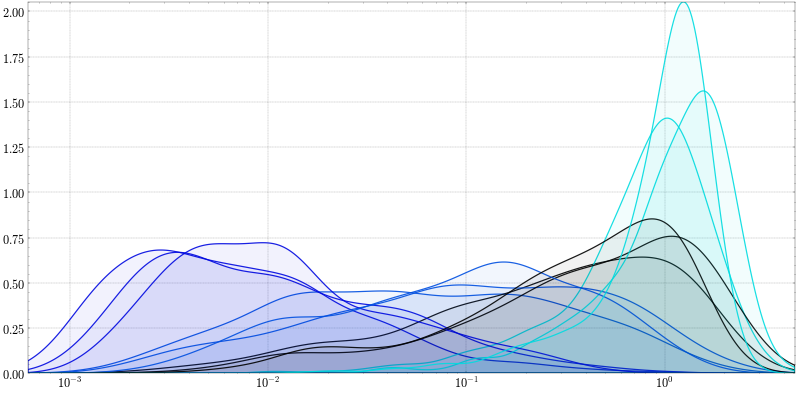

In [59]:
idx = (-1, 1)
sim_idx = np.arange(len(labels))[slice(6, None)]
colours = np.array(bahamas_colours[:2] + ['k'] + bahamas_colours[3:])
plot = plots.PlotDistribution(
    data['nets'][*idx, 0].transforms['targets'](distributions[*idx][:, sim_idx].reshape(-1), back=True),
    log=True,
    y_axes=True,
    density=True,
    colours=np.tile(colours, distributions.shape[-2]).tolist(),
    bins=500,
    alpha_2d=0.05,
    fig_size=(8, 4),
)

,50%,5%,16%,84%,95%,-,+
BAHAMAS-0,0.00586,0.00203,0.00286,0.01414,0.02850,0.00301,0.00828
BAHAMAS-0.1,0.11171,0.01247,0.02955,0.31681,0.55305,0.08216,0.20510
BAHAMAS-0.3,0.65014,0.13613,0.26949,1.15552,1.51306,0.38065,0.50538
BAHAMAS-1,1.17648,0.66193,0.86675,1.54050,1.81096,0.30973,0.36403


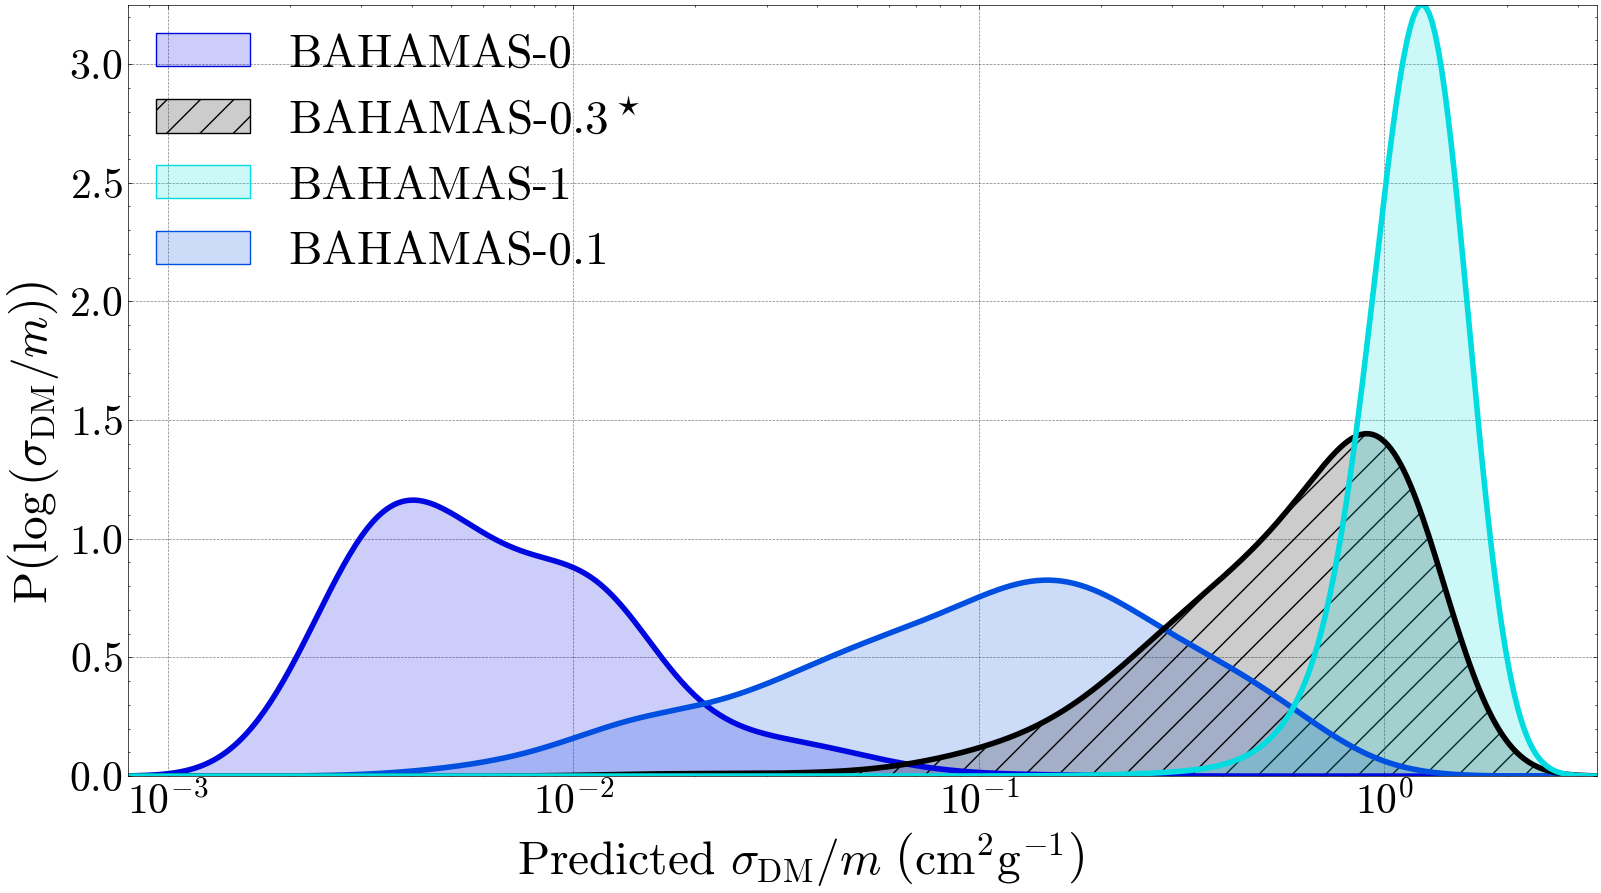

In [60]:
styles = np.array(['-'] * len(labels[sim_idx]), dtype=object)
styles[colours == 'k'] = '--'
hatches = np.array([''] * len(labels[sim_idx]), dtype=object)
hatches[colours == 'k'] = '/'
new_labels = labels[sim_idx].copy().astype(object)
new_labels[colours == 'k'] = new_labels[colours == 'k'] + rf'$^\star$'
plot2 = plots.PlotPlots(
    grids[*idx],
    probs[*idx, sim_idx],
    log_x=True,
    x_label=r'Predicted $\sigma_{\rm DM}/m\ \left(\rm cm^2g^{-1}\right)$',
    y_label=r'${\rm P}\left(\log{\left(\sigma_{\rm DM}/m\right)}\right)$',
    # styles=styles,
    styles='-',
    labels=new_labels,
    colours=colours,
    frameon=False,
    alpha_2d=0.2,
    major=major,
    minor=minor,
    line_width=4,
    axis=True,
    cols=1,
    loc='upper left',
    label_permute=[0, 1, 3, 2],
)
for label, colour, hatch, y_datum in zip(new_labels, colours, hatches, probs[*idx, sim_idx]):
    plot2.plots[plot2.axes].append(plot2.axes.fill_between(
        grids[*idx],
        y_datum,
        hatch=hatch,
        label=label,
        facecolor=(colour, plot2._alpha_2d),
        edgecolors=(colour, plot2._alpha_line),
    ))
plot2.create_legend(**plot2._legend_kwargs)
plot2.axes.set_xlim(np.min(np.array(plot2._data)[(np.array(plot2._y_data) > 1e-3)]), np.max(np.array(plot2._data)[(np.array(plot2._y_data) > 1e-3)]))
# merge_plots(plot2, plot)
plot2.savefig(plots_dir, name='bahamas-0.1_distribution')
pd.DataFrame(quantiles[:, *idx, sim_idx].swapaxes(0, 1), index=labels[sim_idx], columns=[f'{quantile:.0%}' for quantile in list(quantile_values)] + ['-', '+']).round(5)

,BAHAMAS-0,BAHAMAS-0.1,BAHAMAS-1
Mean,24.76,59.88,38.11
STE,0.19,0.34,1.32


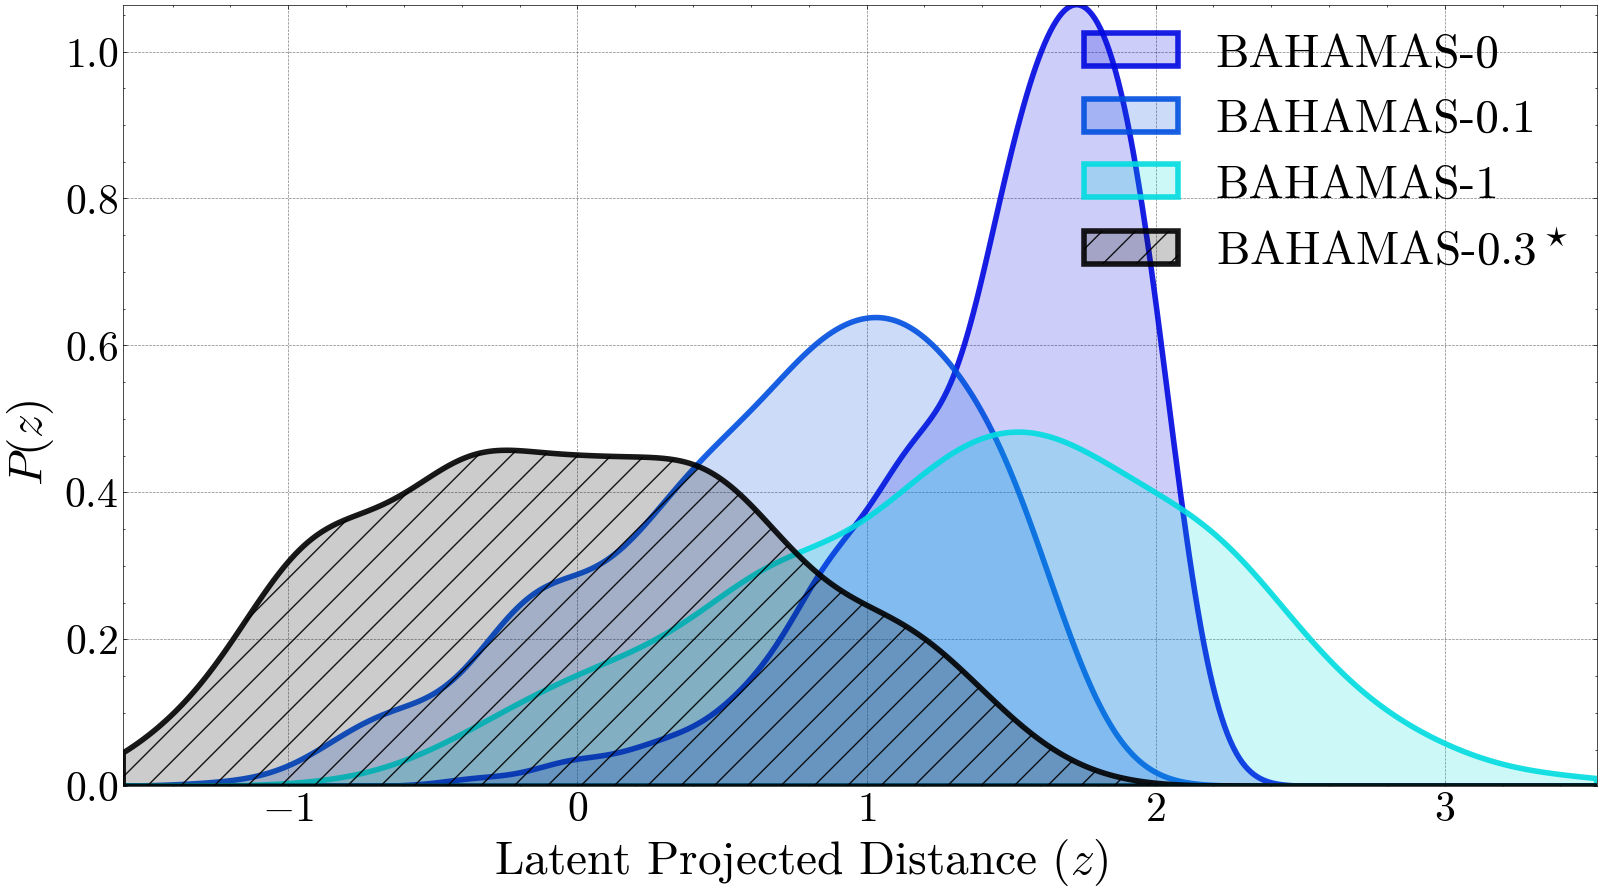

In [62]:
mmd_idx = 2
sub_sim_idx = sim_idx[sim_idx != sim_idx[mmd_idx]]
sub_sim_idx = np.where(sub_sim_idx > sim_idx[mmd_idx], sub_sim_idx - 1, sub_sim_idx)
sub_proj_vecs = proj_vecs[*idx, 0, sim_idx[mmd_idx], sub_sim_idx]

plot = plots.PlotDistribution(
    [*sub_proj_vecs[:, 1], sub_proj_vecs[1, 0]],
    y_axes=True,
    density=True,
    # norm=True,
    bins=500,
    x_labels='Latent Projected Distance $(z)$',
    y_labels='$P(z)$',
    colours=np.append(np.array(colours)[np.arange(len(colours)) != mmd_idx], colours[mmd_idx]),
    labels=np.append(new_labels[np.arange(len(new_labels)) != mmd_idx], new_labels[mmd_idx]),
    hatches=[''] * (len(new_labels) - 1) + ['/'],
    axis=True,
    frameon=False,
    cols=1,
    line_width=4,
    alpha_2d=0.2,
    major=major,
    minor=minor,
    loc='upper left',
)
plot.savefig(plots_dir, name='bahamas-0.1_mmd')
pd.DataFrame((overlap_means[*idx, sim_idx[mmd_idx], sub_sim_idx], overlap_stes[*idx, sim_idx[mmd_idx], sub_sim_idx]), index=['Mean', 'STE'], columns=new_labels[np.arange(len(new_labels)) != mmd_idx]).round(4) * 100

# BAHAMAS AGN Unknown

,50%,5%,16%,84%,95%,-,+
BAHAMAS-0w,0.00670,0.00126,0.00226,0.01876,0.04205,0.00445,0.01206
BAHAMAS-0s,0.01253,0.00200,0.00439,0.02866,0.05466,0.00814,0.01613
BAHAMAS-0,0.01110,0.00208,0.00405,0.02342,0.05250,0.00705,0.01232
BAHAMAS-0.1,0.13017,0.02925,0.05926,0.25848,0.37925,0.07091,0.12832
BAHAMAS-0.3,0.41951,0.15297,0.23844,0.69472,0.94026,0.18107,0.27521
BAHAMAS-1,1.19785,0.64085,0.86736,1.52601,1.72240,0.33049,0.32815


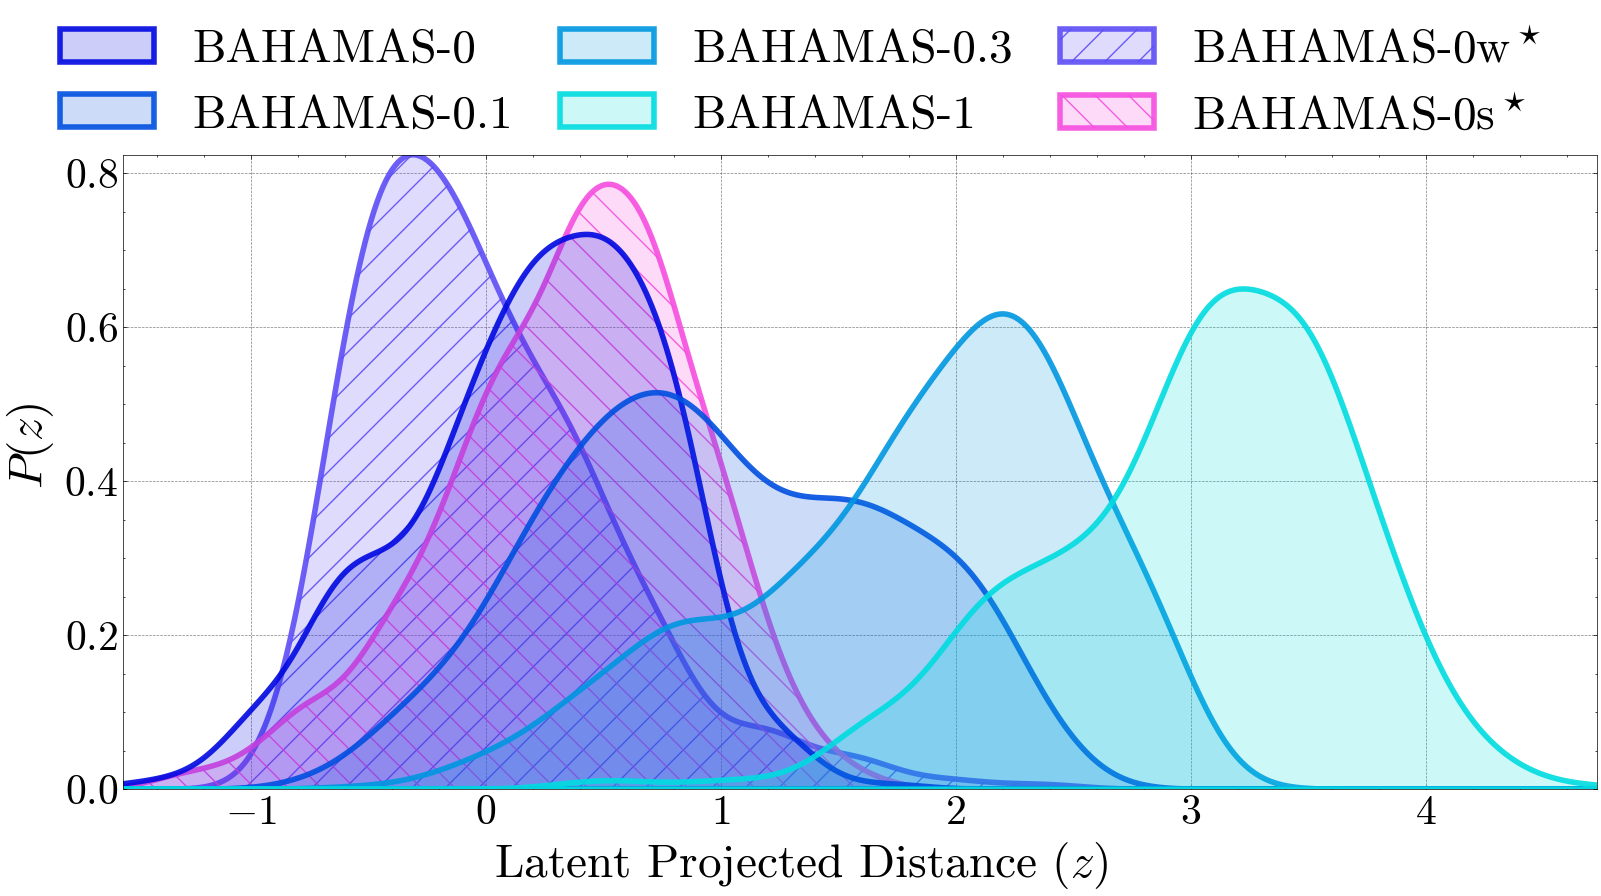

In [23]:
idx = (0, 2)
sim_idx = np.arange(len(labels))[slice(4, None)]
colours = bahamas_agn_colours + bahamas_colours
mmd_idx = 0
sub_sim_idx = sim_idx[sim_idx != sim_idx[mmd_idx]]
sub_sim_idx = np.where(sub_sim_idx > sim_idx[mmd_idx], sub_sim_idx - 1, sub_sim_idx)
sub_proj_vecs = proj_vecs[*idx, 0, sim_idx[mmd_idx], sub_sim_idx]
new_labels = labels[sim_idx].copy().astype(object)
new_labels[:2] = new_labels[:2] + rf'$^\star$'

plot = plots.PlotDistribution(
    [sub_proj_vecs[2, 0], *sub_proj_vecs[:, 1]],
    density=True,
    # norm=True,
    y_axes=True,
    bins=500,
    x_labels='Latent Projected Distance $(z)$',
    y_labels='$P(z)$',
    colours=np.append(colours[mmd_idx], np.array(colours)[np.arange(len(colours)) != mmd_idx]),
    labels=np.append(new_labels[mmd_idx], new_labels[np.arange(len(new_labels)) != mmd_idx]),
    hatches=['/'] + ['\\'] + [''] * (len(labels[sim_idx]) - 2),
    frameon=False,
    cols=3,
    line_width=4,
    alpha_2d=0.2,
    major=major,
    minor=minor,
    columnspacing=1,
    label_permute=[2, 3, 4, 5, 0, 1],
)
plot.savefig(plots_dir, name='bahamas_agn_mmd')
pd.DataFrame(quantiles[:, *idx[:2], sim_idx].swapaxes(0, 1), index=labels[sim_idx], columns=[f'{quantile:.0%}' for quantile in list(quantile_values)] + ['-', '+']).round(5)

In [76]:
print(pd.DataFrame((overlap_means[*idx, sim_idx[mmd_idx], sub_sim_idx], overlap_stes[*idx, sim_idx[mmd_idx], sub_sim_idx]), index=['Mean', 'STE'], columns=new_labels[np.arange(len(new_labels)) != mmd_idx]).round(4) * 100)
mmd_idx = 1
pd.DataFrame((overlap_means[*idx, sim_idx[mmd_idx], sub_sim_idx], overlap_stes[*idx, sim_idx[mmd_idx], sub_sim_idx]), index=['Mean', 'STE'], columns=new_labels[np.arange(len(new_labels)) != mmd_idx]).round(4) * 100

      BAHAMAS-0s$^\star$  BAHAMAS-0  BAHAMAS-0.1  BAHAMAS-0.3  BAHAMAS-1
Mean               77.09      83.86        44.21        21.12       3.85
STE                 0.74       0.63         1.23         1.20       0.39


,BAHAMAS-0w$^\star$,BAHAMAS-0,BAHAMAS-0.1,BAHAMAS-0.3,BAHAMAS-1
Mean,77.09,90.13,46.31,22.35,3.66
STE,0.74,1.31,0.88,0.66,0.05
